# Distribucion de Velocidades, Bayes/Metropolis

A través de fotos aéreas se tienen medidas del alcance de un lanzador de proyectiles. Se tienen cinco valores (en metros): 880, 795, 782, 976, 178. Todas las mediciones tienen una incertidumbre de 5 metros. Los valores diferentes del alcance se deben a diferentes ángulos de lanzamiento, la velocidad inicial es aproximadamente la misma. Utilice el teorema de Bayes y el método de Metropolis-Hastings para encontrar la distribución de probabilidad de la velocidad inicial dados los datos observacionales. La respuesta debe estar implementada dentro de un archivo .py. El código debe producir una única gráfica de la distribución de probabilidad pedidad donde en el título se anotan la velocidad que maximiza la probabilidad, el valor medio y la desviación estándar.

Pista: https://github.com/ComputoCienciasUniandes/MetodosComputacionales/blob/master/ejercicios/2018-10/ej26-1.md

No handles with labels found to put in legend.


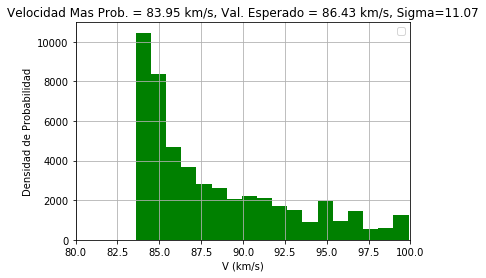

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Defino la función de alcance, que depende de la velocidad de partida y el ángulo theta
def alcance(v, theta):
    g = 9.8
    return v**2 * np.sin(2*theta)/g          #Esta forma viene del link que puso en el enunciado

d_obs = np.array([880, 795, 782, 976, 178])  #Distancias observadas o alcances (datos enunciado)
sigma_d = 5.0                                #Incertidumbre en las medidas

#Defino el Logaritmo de Likelihood para que en vez de una multiplicación, quede como una suma (es mas eficiente)
def loglikelihood(d_obs, sigma_d, v, theta):
    d = d_obs - alcance(v, theta) 
    d = d/sigma_d
    L = -0.5*np.sum(d**2)  
    return L

#Defino el Prior tambien como un logaritmo para ser consistente con el Log-Likelihood
def logprior(v, theta):
    p = -np.inf      #Acotar los parametros, un logprior = -inf equivale a un prior = 0
    if v<100 and v>0 and theta>0 and theta<0.5*np.pi: 
        p = 0.0      #Un Logprior = 0 equivale a un Prior = 1, valores permitidos
    return p
#La probabilidad del prior será uniforme para los valores permitidos y 0 para los no-permitidos
#En consecuencia, el Log-prior será 0 para los permitidos y -inf para los no-permitidos 
#Las cotas de los parametros se obtienen intuitivamente al visualizar los datos (A MANO)

#Creo listas para los parametros que busco estimar y las inicializo con valores aletorios (se pueden elegir a mano)
lista_v = [np.random.random()]
lista_theta = [np.random.random()]

#Defino el posterior (inicializado con valores iniciales de las listas)
#(Recordemos que Posterior = (Likelihood*Prior)/Normalizacion)
#Cuando saco el Log. queda como una suma.
logposterior = [loglikelihood(d_obs, sigma_d, lista_v[0], lista_theta[0]) + logprior(lista_v[0], lista_theta[0])]

#Defino los steps para variar los valores de los parámetros que quiero estimar
sigma_dtheta = 0.1
sigma_dv = 2

N = 50000 #Numero de iteraciones para la búsqueda de parámetros
for i in range(1,N):
    #Defino un valor NUEVO para V respecto al valor de inicializacion, lo mismo para theta.
    propuesta_v  = lista_v[i-1] + np.random.normal(loc=0.0, scale=sigma_dv) 
    propuesta_theta  = lista_theta[i-1] + np.random.normal(loc=0.0, scale=sigma_dtheta)

    #Defino los logposterior de los parametros iniciales y los actuales (viejo y nuevo)
    logposterior_viejo = loglikelihood(d_obs, sigma_d, lista_v[i-1], lista_theta[i-1]) + logprior(lista_v[i-1], lista_theta[i-1])
    logposterior_nuevo = loglikelihood(d_obs, sigma_d, propuesta_v, propuesta_theta) + logprior(propuesta_v, propuesta_theta)
 
    #METROPOLIS
    
    #Este valor de r estima que tan lejos estan los posteriors, si son iguales, r=1.
    r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
    alpha = np.random.random() #es un numero aleatorio entre 0 y 1
    
    #Admite los NUEVOS valores en las listas si el error (mide la diferencia entre los posteriors del parametro
    #viejo y nuevo) es mayor que un numero aletorio entre 0 y 1, de lo contrario agrega nuevamente los anteriores.
    
    #Si el error es grande, admite nuevos valores, de lo contrario repetirá el valor actual.
    
    if(alpha<r):
        lista_v.append(propuesta_v)
        lista_theta.append(propuesta_theta)
        logposterior.append(logposterior_nuevo)
    else:
        lista_v.append(lista_v[i-1])
        lista_theta.append(lista_theta[i-1])
        logposterior.append(logposterior_viejo)
        
#Listas llenas con los parámetros estimados, se convierten en array para facilitar calculos después
lista_v = np.array(lista_v)
lista_theta = np.array(lista_theta)
logposterior = np.array(logposterior)

#Defino el valor más probable como el pico de una pdf (probability density function)
def max_prob(p_a, pdf_p_a):
    ii = np.argmax(pdf_p_a)
    return p_a[ii]

#Defino el valor esperado (coincide con el promedio para N grande) como Int(P(x)*x)dx 
def mean(p_a, pdf_p_a):
    return np.trapz(pdf_p_a*p_a, p_a)

#Defino la desviacion estándar como la raiz de (<x**2>-<x>**2)
def sigma(p_a, pdf_p_a):
    m = mean(p_a, pdf_p_a)
    s = np.trapz(pdf_p_a*p_a*p_a, p_a)
    return np.sqrt(s - m**2)

#Histrograma de las de velocidades estimadas por METROPOLIS y obtencion de valores caracteristicos de la PDF
distro, bins,_ = plt.hist(lista_v, bins=100, density=True)
plt.close() #Cierro el histograma porque después lo grafico otra vez

mp = max_prob(bins[:-1], distro)
m = mean(bins[:-1], distro)
sig = sigma(bins[:-1], distro)



#Este es el modo de imprimir los valores, tambien se puede hacer en la figura con str(Valores)

Args = 'Velocidad Mas Prob. = {:.2f} km/s, Val. Esperado = {:.2f} km/s, Sigma={:.2f}'.format(mp, m, sig) 

plt.figure()
plt.hist(lista_v, 110, color="green")
plt.title(Args)
plt.xlabel("V (km/s)")
plt.ylabel("Densidad de Probabilidad")
plt.xlim(80,100)
plt.grid()
plt.legend()
